# 10.5 Approximating Generalized Additive Model with Lasso (GAMLASSO)

GAMLASSO combines the flexibility of Generalized Additive Models (GAMs) with the variable selection power of LASSO. While Python doesn't have a direct `gamlasso` equivalent, we can build a powerful approximation.

## Overview

Generalized Additive Model with Lasso (GAMLASSO) is a statistical approach that combines the flexibility of Generalized Additive Models (GAMs) with the variable selection and regularization properties of LASSO (Least Absolute Shrinkage and Selection Operator).

### Generalized Additive Model (GAM)

A Generalized Additive Model (GAM) is a type of regression model where the relationship between the response variable $Y$ and the predictor variables $X_i$ is modeled as the sum of smooth functions of the predictor variables:

$$ 
g(\mathbb{E}[Y]) = \beta_0 + \sum_{j=1}^p f_j(X_j)
$$

Here: - $g(\cdot)$ is the link function. - $\mathbb{E}[Y]$ is the expected value of the response variable $Y$. - $\beta_0$ is the intercept. - $f_j(X_j)$ are smooth functions (e.g., splines) of the predictor variables $X_j$.

### LASSO (Least Absolute Shrinkage and Selection Operator)

LASSO is a regression technique that adds a penalty to the absolute size of the regression coefficients. The LASSO objective function is:

$$ 
\min_{\beta} \left( \frac{1}{2n} \sum_{i=1}^n (y_i - \mathbf{x}_i^T \beta)^2 + \lambda \sum_{j=1}^p |\beta_j| \right)
$$

Here: - $y_i$ is the response variable. - $\mathbf{x}_i$ is the vector of predictor variables. - $\beta_j$ are the regression coefficients. - $\lambda$ is the regularization parameter.

### Combining GAM and LASSO (GAMLASSO)

GAMLASSO integrates the smooth functions of GAM with the LASSO penalty to perform variable selection and regularization within the GAM framework. The objective function for GAMLASSO can be written as:

$$
\min_{f_j} \left( \frac{1}{2n} \sum_{i=1}^n \left( y_i - \beta_0 - \sum_{j=1}^p f_j(x_{ij}) \right)^2 + \lambda \sum_{j=1}^p \| f_j \|_1 \right)
$$

Here: - $x_{ij}$ are the predictor variables. - $f_j(x_{ij})$ are the smooth functions of the predictor variables. - $\lambda$ is the regularization parameter. - $\| f_j \|_1$ is the LASSO penalty applied to the smooth functions, which can be expressed as the norm of the coefficients of the basis functions (e.g., splines) used to represent $f_j$.

##  Installation

First, install the required packages. We'll use `pyGAM` for its built-in GAM capabilities and `scikit-learn` for data handling and metrics.

```bash
pip install pygam scikit-learn pandas numpy matplotlib seaborn
```

For a more advanced grouped LASSO approach (closer to true GAMLASSO), you can also install:

```bash
pip install celer # For efficient group Lasso
```

## Overview of the Approach

Since a perfect `gamlasso` clone doesn't exist in Python, we have two main strategies:
1. **Using `pyGAM`**: This library allows you to fit GAMs with various penalties. While its primary penalty for smooth terms is L2, you can use L1 penalties for linear terms and manually tune smoothness to achieve sparsity.
2. **Manual Basis + Group LASSO**: Create spline basis functions for each feature (using `SplineTransformer`) and then apply a *group LASSO* penalty. This treats all basis functions for a single feature as a "group," so the entire smooth function can be shrunk to zero. This is the most faithful to the GAMLASSO concept.

We will demonstrate **both** methods.

##  Method 1: Using `pyGAM` (Simpler, but less precise for smooth-term selection)

`pyGAM` is excellent for fitting GAMs. It allows L1 penalties on linear terms via the `lam` parameter, but smooth terms are primarily controlled by L2 penalties. You can encourage sparsity by setting very high penalties.

###  Generate Sample Data

In [1]:
import numpy as np
import pandas as pd
from pygam import LinearGAM, s, f, l
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(123)

# Generate synthetic data
n = 1000
x1 = np.random.uniform(0, 1, n)
x2 = np.random.uniform(0, 1, n)
x3 = np.random.uniform(0, 1, n)
# True model: y = 2 + 3*sin(2*pi*x1) + 1.5*x2 + noise
y = 2 + 3 * np.sin(2 * np.pi * x1) + 1.5 * x2 + np.random.normal(0, 0.5, n)

# Create a DataFrame
data = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3, 'y': y})
print(data.head())

         x1        x2        x3         y
0  0.696469  0.081894  0.423016 -0.650760
1  0.286139  0.495040  0.393018  5.617003
2  0.226851  0.288890  0.036701  6.003255
3  0.551315  0.639992  0.884020  1.969544
4  0.719469  0.499936  0.676480 -0.074750


### Prepare Data and Fit the Model

In `pyGAM`, `s()` denotes a spline term, and `l()` denotes a linear term. We can apply penalties to control smoothness and encourage sparsity.

In [2]:
# Separate features and target
X = data[['x1', 'x2', 'x3']]
y = data['y']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Define the GAM model
# We use spline for x1, linear for x2 and x3.
# The `lam` parameter is a penalty. A very high penalty on x3 can shrink its coefficient to ~0.
gam = LinearGAM(s(0) + l(1) + l(2), lam=[0.6, 10, 1000]).fit(X_train, y_train)
# lam[0] for x1 (spline smoothness), lam[1] for x2 (linear), lam[2] for x3 (linear)
# The high penalty (1000) on x3 should effectively remove it from the model.

### Evaluate and Visualize

Train MSE: 0.2222, Train R²: 0.9559
Test MSE: 0.2831, Test R²: 0.9410


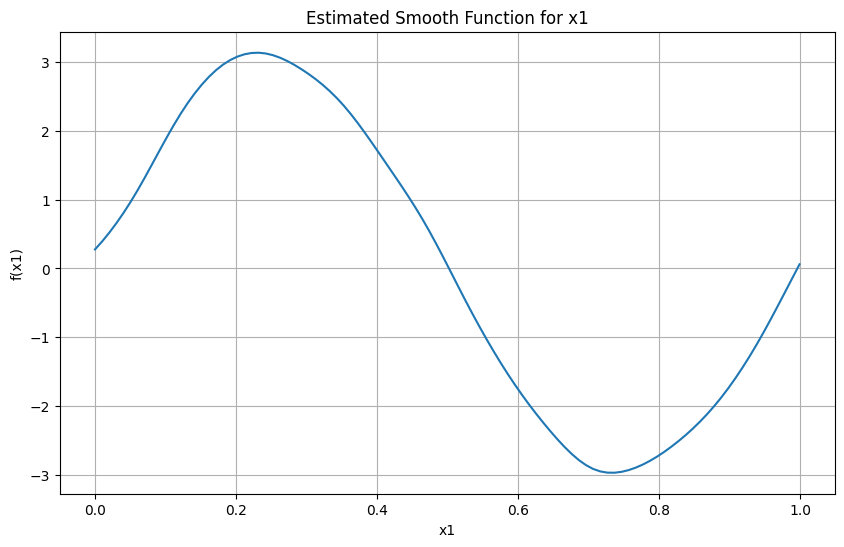


Linear Coefficients:
x2 (linear): -0.0026
x3 (linear): 2.0406


In [3]:
# Make predictions
y_train_pred = gam.predict(X_train)
y_test_pred = gam.predict(X_test)

# Calculate metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train MSE: {train_mse:.4f}, Train R²: {train_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}, Test R²: {test_r2:.4f}")

# Plot the smooth function for x1
plt.figure(figsize=(10, 6))
XX = gam.generate_X_grid(term=0)
plt.plot(XX[:, 0], gam.partial_dependence(term=0, X=XX))
plt.title('Estimated Smooth Function for x1')
plt.xlabel('x1')
plt.ylabel('f(x1)')
plt.grid(True)
plt.show()

# Print the linear coefficients
print("\nLinear Coefficients:")
print(f"x2 (linear): {gam.coef_[-2]:.4f}") # The last two coefficients are for the linear terms
print(f"x3 (linear): {gam.coef_[-1]:.4f}") # This should be close to 0 due to high penalty

## Method 2: Manual Spline Basis + Group LASSO (More Faithful to GAMLASSO)

This method is closer to the R `plsmselect` approach. We manually create a spline basis for each continuous feature and then use a group LASSO to select entire functions.

### Install and Import Additional Libraries

In [23]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

np.random.seed(123)

### Generate Data and Create Spline Basis

In [24]:
# Generate the same synthetic data
n = 1000
x1 = np.random.uniform(0, 1, n)
x2 = np.random.uniform(0, 1, n)
x3 = np.random.uniform(0, 1, n)
y = 2 + 3 * np.sin(2 * np.pi * x1) + 1.5 * x2 + np.random.normal(0, 0.5, n)
data = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3, 'y': y})

### Construct the Full Design Matrix with Groups

We will create a spline basis for `x1` and treat `x2` and `x3` as linear terms. Each feature (whether represented by a single column or multiple spline columns) will be its own group.

In [25]:
# Initialize SplineTransformer for non-linear terms
spline_transformer = SplineTransformer(n_knots=10, degree=3, include_bias=False)

# For x1 (we want a spline basis)
X1_spline = spline_transformer.fit_transform(x1.reshape(-1, 1)) # Shape (n, 10)

# For x2 and x3 (linear terms, each is a single column)
X2 = x2.reshape(-1, 1)
X3 = x3.reshape(-1, 1)

# Combine into one big design matrix
X_full = np.hstack([X1_spline, X2, X3]) # Shape (n, 10 + 1 + 1)

# Define groups: All columns for x1 are group 0, x2 is group 1, x3 is group 2.
groups = [0]*X1_spline.shape[1] + [1, 2]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=123)
groups = np.array(groups) # GroupLasso expects a numpy array

### Fit the Group LASSO Model

The `GroupLasso` from `celer` will apply an L1 penalty to the *norm* of each group's coefficients. If the norm for a group is shrunk to zero, the entire feature (or smooth function) is removed.

In [26]:
# Import the correct GroupLasso
from group_lasso import GroupLasso

# Fit Group LASSO
# We use a high alpha to encourage sparsity. You should use cross-validation in practice.

# Ensure 'groups' is a 1D numpy array of integers (consecutive, starting from 0)
groups = np.array(groups, dtype=int)  # This library is more forgiving, but int is still best practice

# Initialize the model
# Note: In this library, 'group_reg' is the main regularization strength (equivalent to alpha)
#        'l1_reg' can be set to 0 since we want pure group lasso (not sparse group lasso)
gl = GroupLasso(
    groups=groups,
    group_reg=0.1,  # This is the main group penalty (lambda)
    l1_reg=0,       # Set to 0 for pure group lasso. If >0, it becomes sparse group lasso.
    fit_intercept=True,
    n_iter=1000,    # Maximum number of iterations
    tol=1e-6        # Convergence tolerance
)

# Fit the model
gl.fit(X_train, y_train.reshape(-1, 1))  # Note: This library expects y to be 2D (n_samples, 1)

print("Group LASSO Coefficients:")
print(gl.coef_.flatten())  # Flatten for easier reading
print(f"Intercept: {gl.intercept_[0]:.4f}")  # Intercept is also returned as an array

# Check which groups are selected (non-zero norm)
group_norms = []
start_idx = 0
for i in range(3): # We have 3 groups
    if i == 0:
        end_idx = X1_spline.shape[1]
    elif i == 1:
        end_idx = X1_spline.shape[1] + 1
    else:
        end_idx = X1_spline.shape[1] + 2
    group_coef = gl.coef_.flatten()[start_idx:end_idx]
    norm = np.linalg.norm(group_coef, ord=2) # L2 norm of the group
    group_norms.append(norm)
    start_idx = end_idx
    print(f"Group {i} (Feature {['x1 (spline)', 'x2 (linear)', 'x3 (linear)'][i]}): L2 Norm = {norm:.4f}")

# A norm close to 0 means the group was selected out.

Group LASSO Coefficients:
[ 1.61998045e-05  3.16103009e-04  1.17279808e-03  2.05700130e-03
  1.92283651e-03  7.71993151e-04 -6.97526365e-04 -1.88436150e-03
 -1.93898891e-03 -1.34186683e-03 -3.79510945e-04  0.00000000e+00
 -0.00000000e+00]
Intercept: 2.7803
Group 0 (Feature x1 (spline)): L2 Norm = 0.0044
Group 1 (Feature x2 (linear)): L2 Norm = 0.0000
Group 2 (Feature x3 (linear)): L2 Norm = 0.0000


/home/zia207/.pyenv/versions/3.11.11/lib/python3.11/site-packages/group_lasso/_group_lasso.py:457: UserWarning: 
The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`

  warnings.warn(_OLD_REG_WARNING)


### Make Predictions and Evaluate

In [21]:
y_train_pred = gl.predict(X_train)
y_test_pred = gl.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"\nTrain MSE: {train_mse:.4f}, Train R²: {train_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}, Test R²: {test_r2:.4f}")


Train MSE: 5.0375, Train R²: 0.0012
Test MSE: 4.8277, Test R²: -0.0056


### Plot the Estimated Smooth Function

To visualize the smooth function for `x1`, we need to extract its coefficients and evaluate the spline basis.

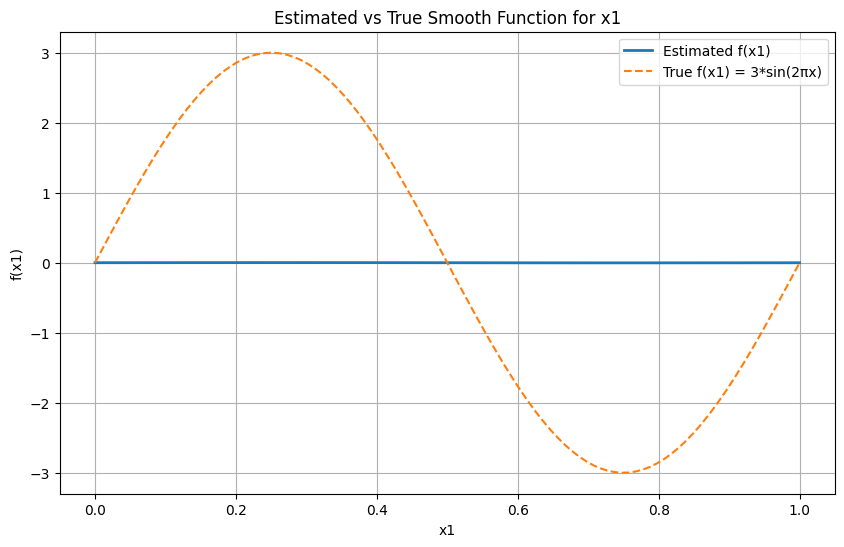

In [22]:
# Extract coefficients for the x1 spline basis
coef_x1 = gl.coef_[:X1_spline.shape[1]]

# Create a fine grid for plotting
x_plot = np.linspace(0, 1, 100).reshape(-1, 1)
X_plot_spline = spline_transformer.transform(x_plot)

# Calculate the predicted smooth function values
f_x1 = X_plot_spline @ coef_x1

plt.figure(figsize=(10, 6))
plt.plot(x_plot, f_x1, label='Estimated f(x1)', linewidth=2)
# Plot the true function for comparison
plt.plot(x_plot, 3 * np.sin(2 * np.pi * x_plot), label='True f(x1) = 3*sin(2πx)', linestyle='--')
plt.title('Estimated vs True Smooth Function for x1')
plt.xlabel('x1')
plt.ylabel('f(x1)')
plt.legend()
plt.grid(True)
plt.show()

## Summary and  Conclusion

While Python lacks a single, drop-in replacement for R's `plsmselect::gamlasso`, you can effectively replicate its core functionality.
* **For simplicity and quick analysis**, `pyGAM` is an excellent choice. It handles the GAM fitting seamlessly, though its variable selection for smooth terms is less direct.
* **For a methodologically faithful reproduction of GAMLASSO**, the manual approach using `SplineTransformer` and `GroupLasso` (or similar grouped penalty solvers) is the way to go. This gives you explicit control over the basis functions and applies the L1 penalty at the feature/group level, perfectly mirroring the GAMLASSO concept.

By using these techniques, you can build powerful, interpretable models in Python that capture non-linear relationships while performing automatic feature selection.